<a href="https://colab.research.google.com/github/Martinmbiro/ViT-from-scratch/blob/main/01.%20ViT%20paper%20replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Getting the Data**
> This section of cells entails downloading the data needed for illustration
+ Data courtesy of [pytorch deep learning](https://github.com/mrdbourke/pytorch-deep-learning/)

### Import necessary packages

In [3]:
!pip install torchinfo

In [4]:
# torch related modules
import torch, torchvision.transforms.v2 as T, os
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torch import nn

import requests, zipfile, pathlib, PIL
import matplotlib.pyplot as plt, numpy as np

In [5]:
# delete images folder
# !rm -rf '/content/images'

### Download & extract data

In [6]:
# directory to download images
IMAGES = pathlib.Path('images')
IMAGES.mkdir(parents=True, exist_ok=True)

# save link to images as a string
data_link = 'https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi_20_percent.zip'
# make request
r = requests.get(url=data_link, stream=True)

if r.status_code == 200:
  # download data from the get request
  with IMAGES.joinpath('data.zip').open(mode='wb') as f:
    for chunk in r.iter_content(chunk_size=300):
      f.write(chunk)

  # extract the zip folder
  with zipfile.ZipFile(file='/content/images/data.zip', mode='r') as z:
    z.extractall(path='/content/images')

else:
  print('Invalid link')

In [7]:
# set up train & test directories
test_dir, train_dir = pathlib.Path('/content/images/test'), pathlib.Path('/content/images/train')

### Define Dataset and DataLoaders

In [8]:
# define image transforms
trans_img = T.Compose([
    T.PILToTensor(),
    T.ToDtype(dtype=torch.float32, scale=True),
    T.Resize(size=(224,224))
])

# function to create list of image paths
def make_data_generator(data_path:pathlib.Path):
  extensions = {'.jpg', '.jpeg', '.png'}
  gen_ls = (i for i in data_path.rglob('*') if i.suffix in extensions)
  return list(gen_ls)

# function to extract label & tensor image out of image path
def make_label_tensor(img_path:pathlib.Path):
  # label
  class_to_idx = {'pizza':0, 'steak':1, 'sushi':2}
  label = class_to_idx[img_path.parent.stem]

  # image to tensor
  img_pil = PIL.Image.open(img_path)
  img_tensor = trans_img(img_pil)

  return (img_tensor, label) # (x,y)

# dataset of food items
class FoodDataset(Dataset):
  def __init__(self, data_path:pathlib.Path):
    super().__init__()
    self.data = make_data_generator(data_path)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    img_path = self.data[idx]
    return make_label_tensor(img_path)

In [9]:
# dataloaders
train_loader = DataLoader(dataset=FoodDataset(train_dir),
                          batch_size=32, pin_memory=True, shuffle=True, num_workers=os.cpu_count())

test_loader = DataLoader(dataset=FoodDataset(test_dir),
                         batch_size=32, pin_memory=True, num_workers=os.cpu_count())

# pick random batch
img_batch, label_batch = next(iter(train_loader))

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


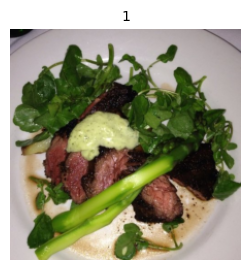

In [10]:
# get random index
rand_int = np.random.choice(range(0,32)).item()
# random image
rand_img = img_batch[rand_int]

# plot random image
f, ax = plt.subplots(figsize=(3,3))
ax.axis(False)
ax.set_title(label_batch[rand_int].item(), fontsize=10)
ax.imshow(rand_img.clamp(min=0, max=1).permute(1,2,0))
plt.show()

## **Replicating the ViT architecture**
To replicate the ViT (Vision Transformer) architecture from scratch, I'll be referencing the original paper, from which it was proposed: [An Image is Worth 16 x 16 words](https://arxiv.org/abs/2010.11929)

🔔 **Note**  
+ More specifically, this notebook will focus on the `ViT-Base` variant of the model. Its hyperparameters are described in _Table 1_ of the [ViT paper](https://arxiv.org/abs/2010.11929)
+ Also, a training resolution of `224` by `224` will be used, as in the original ViT paper (_Table 3_). Also, patch size is `16` by `16`
+ The orignal ViT paper used a batch size of `4096`, but to keep it simple, I'll be using a batch size of `32`

### The most important pieces of the puzzle
Here, I highlight the most important pieces in the ViT paper, which are **Figure 1** (shown above), the **Four equations in section 3.1** and **Table 1**

#### Figure 1
The ViT is a deep learning Neural Network architecture, and like any architecture, is comprised of _layers_ and _blocks_
+ **Layer** - The fundamental building block of a neural network that performs an operation on input data
+ **Block** - A collection of layers, takes an input, performs a series of functions on it, returns an output.
+ **Architecture** - A collection of blocks that performs a series of operations on input data and returns an output

<center>
<img src='https://github.com/Martinmbiro/ViT-from-scratch/raw/refs/heads/main/images/figure-1-inputs-and-outputs.png' alt='ViT paper architecture' width=750 height=400/>
</center>
<center>
Image borrowed from <a href='https://github.com/mrdbourke/pytorch-deep-learning/'>Pytorch deep learning</a>
</center>

#### The four equations
These four equations represent the math behind the four major parts of the ViT architecture.

<center>
<img src='https://github.com/Martinmbiro/ViT-from-scratch/raw/refs/heads/main/images/mapping-the-four-equations-to-figure-1.png' alt='mapping equations to figure 1' />
</center>
<center>
Image borrowed from <a href='https://github.com/mrdbourke/pytorch-deep-learning/'>Pytorch deep learning</a>
</center>

#### Table 1
The ViT variants with different hyperparemeters are described in Table 1


> <img src='https://github.com/Martinmbiro/ViT-from-scratch/raw/refs/heads/main/images/table-1.png' alt='Table 1' width=600/>  

> Source: [ViT Paper](https://arxiv.org/abs/2010.11929)

Breaking the hyperparameters down:
+ **Layers** - Number of transformer encoders
+ **Hidden size $D$** - This is the embedding dimension throughout the architecture, this will be the size of the vector that our image gets turned into when it gets patched and embedded
+ **MLP size** - Number of hidden units in the MLP layers
+ **Heads** - Number of heads in Multi-Head Attention layers

### Equation 1

Equation 1 deals with splitting the image into patches, then creating the patch, position and patch embedding

$$ \begin{aligned} \mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D} \end{aligned} $$


#### Background
Note the following opening paragraph from section 3.1 of the ViT paper
> <img src='https://github.com/Martinmbiro/ViT-from-scratch/raw/refs/heads/main/images/verbose-model-overview.png' alt='section 3.1 paragraph 1' width=600/>  

> Source: [ViT Paper](https://arxiv.org/abs/2010.11929)


Breaking that down would mean
```
  * (H, W) -> Resolution of original image (224, 224)
  * C -> Number of channels, = 3 for a coloured image
  * (P, P) -> Resolution of the patches (16, 16)
  * N = (HW)/P^2 -> Number of patches, which also serves as the effective input sequence length of the transformer
  * xp (a patch) is an element of a real number of shape N x (P^2 x C)

  * D -> Size of patch embbedding, = 768 for ViT-Base model variant
```

#### Calculate patch embedding input and ouput shapes by hand

In [11]:
# hard-coding the values
H, W, C, P = rand_img.shape[1], rand_img.shape[2], 3, 16 # Height, Width, Colour channels, Patch size
D = 768 # size of patch embedding for ViT-Base model variant

# no. patches
N = int((H*W)/P**2)

# print
print(f'Image resolution: {(H,W)}')
print(f'Patch size: {(P, P)}')
print(f'No. of patches: {int(N)}')
print(f'Embedding Layer input shape (single 2D image): {(C, H, W)}')
print(f'Embedding Layer output shape (single 2D image patches flattened): {N, (P**2*C)}')

Image resolution: (224, 224)
Patch size: (16, 16)
No. of patches: 196
Embedding Layer input shape (single 2D image): (3, 224, 224)
Embedding Layer output shape (single 2D image patches flattened): (196, 768)


#### Visualize single patched image - using `matplotlib`
📝 **Note**  
+ This is just for visualization, and up next, I'll be using `pytorch` layers to split the image into patches

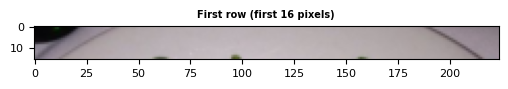

In [12]:
# define figure & subplot
rand_img_permuted = rand_img.permute(1,2,0)

# visualize the first row of 16 pixels (patch size)
f, ax = plt.subplots(figsize=(6,6))
ax.tick_params(axis='both', labelsize=8)
ax.set_title('First row (first 16 pixels)', weight='bold', fontsize=7)
                          # H   W  C
ax.imshow(rand_img_permuted[:P, :, :].clamp(min=0, max=1));

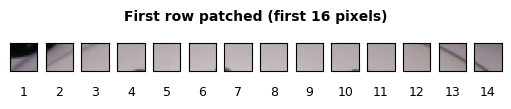

In [13]:
# break first row into patches of 16 by 16 pixels
f, axs = plt.subplots(nrows=1, ncols=H//P, figsize=(5,5), layout='compressed')
for i, j, ax in zip(range(0,224,P), range(1, N+1), axs):
                            # H     W     C
  ax.imshow(rand_img_permuted[:P, i:i+P, :].clamp(min=0, max=1))
  ax.yaxis.set_visible(False)
  ax.xaxis.set_ticklabels([])
  ax.tick_params(axis='both', bottom=False)
  ax.set_xlabel(j, fontsize=9)

f.suptitle('First row patched (first 16 pixels)', weight='bold', fontsize=10)
plt.show()

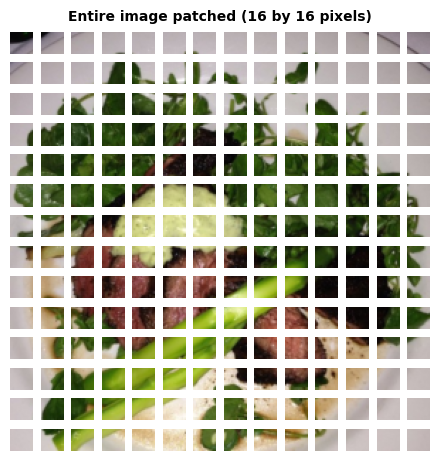

CPU times: user 6.07 s, sys: 60.3 ms, total: 6.13 s
Wall time: 7.63 s


In [14]:
%%time
# break entire image into patches of 16 by 16 pixels
f, axs = plt.subplots(nrows=H//P, ncols=H//P, figsize=(4.5,4.5), layout='compressed')
for j, k in enumerate(range(0, H, P)):
  for i, ax in zip(range(0, H, P), axs[j]):
                              #   H     W     C
    ax.imshow(rand_img_permuted[k:k+P, i:i+P, :].clamp(min=0, max=1))
    ax.axis(False)

f.suptitle('Entire image patched (16 by 16 pixels)', weight='bold', fontsize=10)
plt.show()

#### Creating image patches using [`torch.nn.Conv2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
📝 **Note**  
Section 3.1, **Hybrid Architecture** of the ViT paper, describes that:
1. Image patches can be extracted from a **CNN** feature map
2. Input sequence is then obtained by **flattening** the **spatial dimensions of the feature map** _(meaning its Height & Width)_ and **projecting** _(changing its shape)_ to the **Transformer dimension** (Hidden Size $D$ from Table 1 of the ViT paper)



+ Hence, by setting the `stride` and `kernel_size` equal to the patch shape `(16, 16)`, and `out_features` as `768` (same as $D$ value in Table 1) we can get `768` different feature maps that split the image into a `14` by `14` grid of patches
+ Flattening is similar to stacking the values from the `768` feature maps at that location into a single `768`-dimensional vector. That vector is the **patch embedding**
+ Flattenig all spatial locations, you have `14` by `14` = `196` patches, each with a `768` dimensional vector
+ The resulting shape from flattening becomes `(1, 196, 768)`. Hence, each patch embedding is just a slice through all feature maps at one spatial location

In [15]:
# define a Conv2d layer
conv2d = nn.Conv2d(
    in_channels=3, # 3 color channels for an RGB image
    out_channels=768, # from Table 1: Hidden size D, this is the embedding size
    kernel_size=P, stride=P) # same for both means no overlap

In [16]:
# pass the rand_img through the convolutional layer
conv_output = conv2d(rand_img.unsqueeze(0)) # unsqueeze for batch size
print(f'Convolutional Layer output shape: {conv_output.shape}')

Convolutional Layer output shape: torch.Size([1, 768, 14, 14])


In [17]:
# shape of a random feature map:
print(f'Shape of a random feature map: {conv_output[:, 0, :, :].squeeze().shape}')

Shape of a random feature map: torch.Size([14, 14])


#### Visualizing random feature maps from the convolution operation
+ Here, I'll take random feature maps from the output vector and plot them

In [18]:
# generate random indices
rand_idx = np.random.choice(a=np.random.randint(0, 768, 100), size=10, replace=False)

rand_idx

array([657, 299,  20, 368, 362, 109, 702, 402, 453, 445])

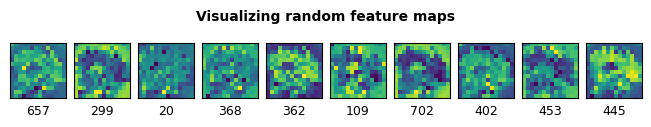

In [19]:
# visualize random feature maps
f, axs = plt.subplots(nrows=1, ncols=10, layout='compressed')

for i, ax in zip(rand_idx, axs):
  ax.imshow(conv_output[:, i, :, :].squeeze().detach().numpy())
  ax.yaxis.set_visible(False)
  ax.tick_params(axis='x', bottom=False)
  ax.xaxis.set_ticks([])
  ax.set_xlabel(i, fontsize=9)

f.suptitle('Visualizing random feature maps', weight='bold', fontsize=10)
plt.show()

#### Flatten the `Conv2d` output using [`torch.nn.Flatten`](https://docs.pytorch.org/docs/stable/generated/torch.nn.modules.flatten.Flatten.html)
+ I'll flatten the spatial dimensions of the output to the convolutional layer `(1, 768, 14, 14)`
+ Then I'll [`transpose`](https://docs.pytorch.org/docs/stable/generated/torch.Tensor.transpose.html) the flattened tensor to swap the last two dimensions

In [20]:
# define Flatten layer
flatten = nn.Flatten(start_dim=2, end_dim=3)

# flatten, view shape
flatten(conv_output).shape

torch.Size([1, 768, 196])

In [21]:
# flatten & transpose
patch_embeddings = flatten(conv_output).transpose(1,2)
print(f'Patch embedding shape: {patch_embeddings.shape}')

Patch embedding shape: torch.Size([1, 196, 768])


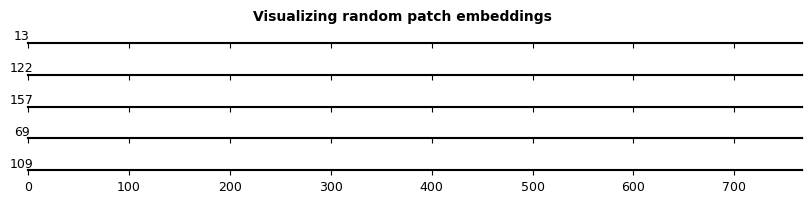

In [22]:
# visualizing random feature embeddings
rand_idx = np.random.choice(a=np.random.randint(0, 196, 10), size=5, replace=False)

f, axs = plt.subplots(nrows=5, ncols=1, figsize=(10, 2), layout='none', sharex=True)

for i, ax in zip(rand_idx, axs.flat):
  ax.imshow(patch_embeddings[:, i, :].detach().numpy())
  ax.set_ylabel(i, rotation=0, fontsize=9)
  ax.yaxis.set_ticks([])
  ax.tick_params(axis='x', labelsize=9)

f.suptitle('Visualizing random patch embeddings', weight='bold', fontsize=10)
plt.show()


#### Turning the patch embedding layer in to a pytorch [`nn.Module`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Module.html)
+ I'll put all the steps above into a layer that subclasses `torch.nn.Module` like such:


In [23]:
class PatchEmbedding(nn.Module):
  # initialize class with relevant variables
  def __init__(self, in_channels=3, patch_size=16, embedding_dim=768):
    super().__init__()

    # create patches from image
    self.conv = nn.Conv2d(
        in_channels=in_channels, out_channels=embedding_dim, stride=patch_size,
        kernel_size=patch_size)

    # flatten output from convolution operation
    self.flatten = nn.Flatten(start_dim=2, end_dim=3)

  # overwrite the forward method
  def forward(self, x):
    return self.flatten(self.conv(x)).transpose(1,2) # flatten, then transpose

In [24]:
# create object of PatchEmbedding
patcher = PatchEmbedding()

patch_embeddings = patcher(rand_img.unsqueeze(0))
patch_embeddings.shape

torch.Size([1, 196, 768])

#### Getting a summary of the `PatchEmbedding` layer

In [25]:
summary(model=patcher, input_size=(1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'trainable'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Trainable
PatchEmbedding                           [1, 3, 224, 224]          [1, 196, 768]             True
├─Conv2d: 1-1                            [1, 3, 224, 224]          [1, 768, 14, 14]          True
├─Flatten: 1-2                           [1, 768, 14, 14]          [1, 768, 196]             --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

#### Creating the class token embedding
📝 **Note**   
From paragraph 2 of Section 3.1 of the paper
+ A **learnable** embedding is _prepended_ to the sequence of embedded patches $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$ whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation
+ Hence, we'll create a learnable embedding in the shape of embedding dimension $D$, then [`torch.concatenate`](https://docs.pytorch.org/docs/stable/generated/torch.concatenate.html) it along the patches dimension `1`. Note, all input tensors must have the same same shape in every dimension except for the dimension being concatenated. They are concatenated in the order passed
+ To make a `torch.Tensor` learnable, we'll have to wrap it around a [`nn.Parameter`](https://docs.pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html). Ideally, this would be an attribute in a class that subclasses `nn.Module` for automatic gradient tracking


In [26]:
# shape of embedding layer output
patch_embeddings.shape

torch.Size([1, 196, 768])

In [27]:
# class token as a learnable parameter
# NOTE: class token set to zeros for visualization
#     otherwise, would be initialized using torch.randn()
class_token = nn.Parameter(
    data=(torch.zeros(size=(1, 1, D))),
    requires_grad=True)

In [28]:
# concatenate the two, with class token first
patch_and_class_embeddings = torch.concatenate(
    tensors=(class_token, patch_embeddings), dim=1)

# should have zeros at the start
patch_and_class_embeddings

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0395,  0.3314,  0.0281,  ...,  0.0697, -0.2277,  0.2389],
         [-0.0499,  0.3210, -0.0444,  ...,  0.1317, -0.2790,  0.3371],
         ...,
         [ 0.0366,  0.2123, -0.1449,  ...,  0.1466, -0.3145,  0.4026],
         [ 0.0567,  0.1585, -0.1463,  ...,  0.1455, -0.3091,  0.4000],
         [ 0.0557,  0.1491, -0.1367,  ...,  0.1417, -0.3014,  0.3855]]],
       grad_fn=<CatBackward0>)

In [29]:
# shape of the tensor when patch positional embeddings are prepended
patch_and_class_embeddings.shape

torch.Size([1, 197, 768])

#### Creating the position embedding
📝 **Note**   
From paragraph 3 of Section 3.1 of the VitT paper
+ Position embeddings are **added** to the patch embeddings to retain positional information and the resulting sequence of embedding vectors serves as input to the encoder
+ Standard **learnable 1D position embeddings** are used
+ From Equation 1, $\mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1)\times D}$, meaning positional embedding $\mathbf{E}_{\text {pos }}$ is an element of a real number with shape `(N+1, D)`, where
>+ `N` = Total number of patches = `196`
>+ `D` = Embedding dimension = `768`
+ Hence, the shape of $\mathbf{E}_{\text {pos }}$ is `(197, 768)`
+ To make a `torch.Tensor` learnable, we'll have to wrap it around a [`nn.Parameter`](https://docs.pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html). Ideally, this would be an attribute in a class that subclasses `nn.Module` for automatic gradient tracking


In [30]:
# variables N and D are decleared earlier in the notebook
# NOTE: class token set to ones for visualization
#       otherwise, would be initialized using torch.randn()
pos_embedding = nn.Parameter(
    data=(torch.ones(N+1, D)), requires_grad=True)

pos_embedding.shape

torch.Size([197, 768])

In [31]:
# adding position embedding to patch & class embedding
input_to_transformer = patch_and_class_embeddings + pos_embedding # same to torch.add()

# shape should not change
input_to_transformer.shape

torch.Size([1, 197, 768])

In [32]:
# peek at the output tensor
input_to_transformer

tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.9605, 1.3314, 1.0281,  ..., 1.0697, 0.7723, 1.2389],
         [0.9501, 1.3210, 0.9556,  ..., 1.1317, 0.7210, 1.3371],
         ...,
         [1.0366, 1.2123, 0.8551,  ..., 1.1466, 0.6855, 1.4026],
         [1.0567, 1.1585, 0.8537,  ..., 1.1455, 0.6909, 1.4000],
         [1.0557, 1.1491, 0.8633,  ..., 1.1417, 0.6986, 1.3855]]],
       grad_fn=<AddBackward0>)

### Equation 2
Equation 2 entails applying Multi-head Self-Attention (MSA) to normalized image patches and adding the result to the previous layer's output (residual connection) to enable global feature interaction.

$$ \begin{aligned} \mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \end{aligned} $$

#### Background
 > <img src='https://github.com/Martinmbiro/ViT-from-scratch/raw/refs/heads/main/images/msa_appendix.png' width=700 alt='MSA appendix'/>  

> Source: [ViT Paper](https://arxiv.org/abs/2010.11929)


##### Multihead Self Attention (MSA)
The image above highlights the triple embedding input to the MSA layer.  

📝 **Note**    

+ This is known as `query`, `key`, `value` input or qkv for short which is fundamental to the self-attention mechanism.
+ In our case, the triple embedding input will be three versions of the output of the Norm layer, one for `query`, `key` and `value`.
+ MSA layer in a Vision Transformer (ViT) is the core mechanism responsible for modeling global dependencies and understanding the relationships between different patches of an image.
 + It allows each patch to interact with every other patch in the image, enabling the model to capture long-range, context-aware, and global dependencies
+ The MSA layer can be implemented using [`torch.nn.MultiheadAttention`](https://docs.pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html#torch.nn.MultiheadAttention.forward) with the following parameters
>+ `embed_dim` - total dimension of the model from Table 1 (Hidden size $D$)
>+ `num_heads` – Number of parallel attention heads from Table 1 (Heads)
>+ `dropout` – Dropout probability on `attn_output_weights`. (according to Appendix B.1, dropout isn't used after the qkv-projections)
>+ `batch_first` – If `True`, then the input and output tensors are provided as `(batch, seq, feature)`. In our case, this is `True`

##### Layer Normalization (LN) layer
📝 **Note**   
+ It can be implemented using pytorch's [`torch.nn.LayerNorm`](https://docs.pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html)
+ It normalizes the activations within each individual sample (across the feature / embedding dimension), ensuring they have a mean of zero and a standard deviation of one


#### Building the MSA block with using pytorch layers
📝 **Note**   
+ The MSABlock defined below does not implement a skip connection yet
+ This will be implemented later when building out the final ViT architecture

In [33]:
# MSA Block
# NOTE: skip connection note yet included
class MSABlock(nn.Module):
  def __init__(self,
               embed_dim=768, # Hidden size D - Table 1
               num_heads=12, # Heads - Table 1 for ViT-Base variant
               dropout=0.0): # No droupout was used in the paper for MSA
    super().__init__()

    # define Norm Layer
    self.ln = nn.LayerNorm(normalized_shape=embed_dim)

    # define MultiHead layer
    self.msa = nn.MultiheadAttention(
        embed_dim=embed_dim,
        num_heads=num_heads,
        dropout=dropout,
        batch_first=True) # since out batch dimension comes first

  def forward(self, x):
    x = self.ln(x) # normalize first

    # x will be used for query, key and value embeddings
    attn_output, _ = self.msa(query=x, key=x, value=x, need_weights=False)

    return attn_output # in shape(batch_size, no_tokens, embed_dim)


In [34]:
# create an object of MLPBlock class above
msa_block = MSABlock()

# pass the input_to_transformer tensor
msa_block_output = msa_block(input_to_transformer)

msa_block_output

tensor([[[ 0.2523, -0.7048, -0.5471,  ...,  0.0863,  0.4743,  0.3721],
         [ 0.2581, -0.6968, -0.5375,  ...,  0.1022,  0.4667,  0.3679],
         [ 0.2491, -0.7051, -0.5441,  ...,  0.1062,  0.4618,  0.3599],
         ...,
         [ 0.2501, -0.7039, -0.5426,  ...,  0.1072,  0.4607,  0.3597],
         [ 0.2495, -0.7037, -0.5429,  ...,  0.1069,  0.4602,  0.3596],
         [ 0.2494, -0.7038, -0.5432,  ...,  0.1067,  0.4603,  0.3595]]],
       grad_fn=<TransposeBackward0>)

In [35]:
# print the input tensor into MSABlock
input_to_transformer

tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.9605, 1.3314, 1.0281,  ..., 1.0697, 0.7723, 1.2389],
         [0.9501, 1.3210, 0.9556,  ..., 1.1317, 0.7210, 1.3371],
         ...,
         [1.0366, 1.2123, 0.8551,  ..., 1.1466, 0.6855, 1.4026],
         [1.0567, 1.1585, 0.8537,  ..., 1.1455, 0.6909, 1.4000],
         [1.0557, 1.1491, 0.8633,  ..., 1.1417, 0.6986, 1.3855]]],
       grad_fn=<AddBackward0>)

In [36]:
# shape of output from MSABlock
msa_block(input_to_transformer).shape

torch.Size([1, 197, 768])

🔔 **Note**
> Despite the input and output out shape of the MSA block being the same `(1, 197, 768)`, the values have changed, as seen above

### Equation 3
Equation 3 defines the application of a multi-layer perceptron (MLP) block preceded by Layer Normalization and followed by a residual connection to refine the patch representations within each transformer encoder layer.

$$ \begin{aligned} \mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\ \end{aligned} $$

#### Background
📝 **Note**   
From paragraph 4 of section 3.1 of the ViT paper,
+ The MLP contains two layers with a GELU non-linearity
>+ The two layers refers to linear layer, [`nn.Linear`](https://docs.pytorch.org/docs/2.9/generated/torch.nn.Linear.html), and GELU activation can be implemented using [`nn.GELU`](https://docs.pytorch.org/docs/2.9/generated/torch.nn.GELU.html)
>+ Recall from Table 1 that MLP size for ViT-Base is specified as `3072`
>+ Also, recall from `nn.Linear` rules, the `in_features` parameter should be same as the size of the last dimension of the input tensor (in this case, the tensor from MSA block `(1, 197, 768)`

Also, from Appendix B.1 (Training),
+ **Dropout when used is applied after every dense layer** _(except for the qkv-projections and directly aftr adding positional-patch embeddings)_
>+ _dense layer / feedforward layer_ mean the same as linear layer [`nn.Linear`](https://docs.pytorch.org/docs/2.9/generated/torch.nn.Linear.html)
>+ Also, from Table 3 on Hyperparameters for training, a [`nn.Dropout`](https://docs.pytorch.org/docs/2.9/generated/torch.nn.Dropout.html) of `0.1` was used for ViT-B variant
>+ It is also standard best practice to place Dropout after non-linear activation function

In a Multilayer Perceptron (MLP), the general convention is that a linear layer is followed by a non-linear layer. Hence, in our case with two linear layes, a GELU and dropout, the pattern would be:
```
  linear_layer -> GELU -> Dropout -> Linear_layer -> Dropout
```

#### Building MLP block using pytorch layers
🔔 **Note**
+ The MLP block implemented below does not include a skip connection yet
+ This will be implemented later when building out the final ViT architecture

In [37]:
# MLP Block
# NOTE: skip connection note yet included
class MLPBlock(nn.Module):
  def __init__(self,
               embed_dim=768, # Hidden size D - Table 1
               mlp_size=3072, # MLP size - Table 1 for ViT-Base variant
               dropout=0.1): # Table 3 on Hyperparameters for training, for ViT-B
    super().__init__()

    # define Layer Norm
    self.ln = nn.LayerNorm(normalized_shape=embed_dim)

    # define MLP layer
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embed_dim, out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout), # dropout after every dense layer
        nn.Linear(in_features=mlp_size, out_features=embed_dim),
        nn.Dropout(p=dropout)) # dropout after every dense layer

  def forward(self, x):
    return self.mlp(self.ln(x))

In [38]:
# create an object of MLPBlock class above
mlp_block = MLPBlock()

# pass the output from msa block
mlp_block_output = mlp_block(msa_block_output)

mlp_block_output

tensor([[[ 2.7042e-01,  2.1826e-01,  8.8603e-02,  ..., -2.1008e-01,
          -2.3592e-02, -0.0000e+00],
         [ 1.7707e-01,  0.0000e+00,  1.2232e-01,  ..., -1.0191e-01,
          -7.3862e-02, -3.7181e-01],
         [ 1.6598e-01,  3.0270e-01,  1.5675e-02,  ...,  6.2634e-03,
           4.5117e-02, -4.1352e-01],
         ...,
         [ 1.7657e-01,  2.6874e-01,  4.9778e-02,  ..., -1.3098e-01,
           0.0000e+00, -0.0000e+00],
         [ 2.3553e-01,  1.9702e-01, -2.2613e-04,  ...,  7.1990e-02,
          -5.5504e-02, -0.0000e+00],
         [ 1.6228e-01,  3.5517e-01,  1.1873e-01,  ..., -1.7541e-01,
           5.8234e-02, -4.0900e-01]]], grad_fn=<MulBackward0>)

In [39]:
# shape of output from MLP block
mlp_block_output.shape

torch.Size([1, 197, 768])

In [40]:
# view inputto the MLP block
msa_block_output

tensor([[[ 0.2523, -0.7048, -0.5471,  ...,  0.0863,  0.4743,  0.3721],
         [ 0.2581, -0.6968, -0.5375,  ...,  0.1022,  0.4667,  0.3679],
         [ 0.2491, -0.7051, -0.5441,  ...,  0.1062,  0.4618,  0.3599],
         ...,
         [ 0.2501, -0.7039, -0.5426,  ...,  0.1072,  0.4607,  0.3597],
         [ 0.2495, -0.7037, -0.5429,  ...,  0.1069,  0.4602,  0.3596],
         [ 0.2494, -0.7038, -0.5432,  ...,  0.1067,  0.4603,  0.3595]]],
       grad_fn=<TransposeBackward0>)

🔔 **Note**
> Despite the input and output out shape of the MSA block being the same `(1, 197, 768)`, the values have changed, as seen above

#### Building the transformer encoder from the custom MSA and MLP blocks
🔔 **Note**  
From paragraph 4 of section 3.1,
+ The transformer encoder consists of **alternating layers of self attention (MSA) and MLP blocks** _(Layernorm) is applied before every block and residual connections after every block_
+ Here, I'll define a custom `TransformerEncoderBlock` using the `MSABlock` and `MLPBlock` we've already implemented
+ Skip / residual connections will be implemented here

In [41]:
# TransformerEncoderBlock
# NOTE: skip connection are implemented here
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embed_dim=768, # Hidden size D - Table 1
               num_heads=12, # Heads - Table 1 for ViT-Base variant
               mlp_size=3072, # MLP size - Table 1 for ViT-Base variant
               msa_dropout=0.0, # No droupout was used in the paper for MSA
               mlp_dropout=0.1, # Table 3 on Hyperparameters for training, for ViT-B
              ):
    super().__init__()

    # define MSA block
    self.msa = MSABlock(embed_dim=768, num_heads=12, dropout=0.0)

    # define MLP block
    self.mlp = MLPBlock(embed_dim=768, mlp_size=3072, dropout=0.1)

  def forward(self, x):
    x = self.msa(x) + x # residual connection after MSA block
    x = self.mlp(x) + x # residual connection after MLP block
    return x

In [42]:
# shape of input to transformer (patch+class+positional embeddings)
input_to_transformer.shape

torch.Size([1, 197, 768])

In [43]:
input_to_transformer

tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.9605, 1.3314, 1.0281,  ..., 1.0697, 0.7723, 1.2389],
         [0.9501, 1.3210, 0.9556,  ..., 1.1317, 0.7210, 1.3371],
         ...,
         [1.0366, 1.2123, 0.8551,  ..., 1.1466, 0.6855, 1.4026],
         [1.0567, 1.1585, 0.8537,  ..., 1.1455, 0.6909, 1.4000],
         [1.0557, 1.1491, 0.8633,  ..., 1.1417, 0.6986, 1.3855]]],
       grad_fn=<AddBackward0>)

In [44]:
# an object of TransformerEncoderBlock
t_encoder = TransformerEncoderBlock()

t_encoder(input_to_transformer)

tensor([[[1.3401, 0.2842, 0.1287,  ..., 0.6676, 1.2525, 1.4979],
         [0.9677, 0.8968, 0.3649,  ..., 1.0843, 1.2050, 1.5121],
         [0.8774, 0.8363, 0.6093,  ..., 1.2236, 1.2458, 1.6998],
         ...,
         [0.9993, 0.6159, 0.4116,  ..., 1.1517, 1.0381, 1.5487],
         [0.9154, 0.5321, 0.5673,  ..., 1.0528, 1.1366, 1.6028],
         [1.5220, 0.6039, 0.5622,  ..., 0.9912, 0.9752, 1.6090]]],
       grad_fn=<AddBackward0>)

In [45]:
# shape of output from transformer encoder block
t_encoder(input_to_transformer).shape

torch.Size([1, 197, 768])

##### Get summary of custom `TransformerEncoderBlock`

In [46]:
summary(model=t_encoder,
        input_data=input_to_transformer)

Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoderBlock                  [1, 197, 768]             --
├─MSABlock: 1-1                          [1, 197, 768]             --
│    └─LayerNorm: 2-1                    [1, 197, 768]             1,536
│    └─MultiheadAttention: 2-2           [1, 197, 768]             2,362,368
├─MLPBlock: 1-2                          [1, 197, 768]             --
│    └─LayerNorm: 2-3                    [1, 197, 768]             1,536
│    └─Sequential: 2-4                   [1, 197, 768]             --
│    │    └─Linear: 3-1                  [1, 197, 3072]            2,362,368
│    │    └─GELU: 3-2                    [1, 197, 3072]            --
│    │    └─Dropout: 3-3                 [1, 197, 3072]            --
│    │    └─Linear: 3-4                  [1, 197, 768]             2,360,064
│    │    └─Dropout: 3-5                 [1, 197, 768]             --
Total params: 7,087,872
Trainable params: 7,087,872
Non-tr

### Equation 4
Equation 4  represents the final classification head, which takes the layer-normalized state of the prepended class token from the last transformer encoder block to generate the final image classification prediction.

$$ \begin{aligned} \mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_{L}^{0}\right) & & \end{aligned} $$

📝 **Note**   
+ The final `nn.Layernorm` in ViT is applied to the entire `(B, N+1, D)` output of the last transformer block
+ Only after that is the CLS token `z[:,0]` selcted and fed to the classifier head
+ From paragraph 2 of section 3.1, _The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning_

In [68]:
# Classifier Head
class ClassificationHead(nn.Module):
  def __init__(self,
               embed_dim=768, # Hidden size D - Table 1
               num_classes=3): # assume 3 classes as is the case for the dataset used here
    super().__init__()

    # single linear layer
    self.head = nn.Linear(in_features=embed_dim, out_features=num_classes)

  def forward(self, x):
    # select only CLS token (prepended at index 0)
    cls_token = x[:, 0]
    return self.head(cls_token)

In [69]:
# an object of classifier head
head = ClassificationHead()

In [70]:
# pass output from transformer block
head(t_encoder(input_to_transformer))

tensor([[ 1.0712, -0.4458,  0.8197]], grad_fn=<AddmmBackward0>)

In [ ]:
# to be implemented in final ViT architecture:

# [TransformerEncoderBlock(embed_dim=768, num_heads=12, mlp_size=3072,
#                msa_dropout=0.0, mlp_dropout=0.1) for _ in range(12)]

### Creating the ViT
> With all the pieces of the puzzle in place, all the layers above can be combined to form the Vision Transformer architecture 👏